# 长短期记忆网络（LSTM）

In [26]:
import torch
from torch import nn
from d2l import torch as d2l
import random
import collections
import math
import re
from torch.nn import functional as F

In [10]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',

                '090b5e7e70c295757f55df93cb0a180b9691891a')
# 定义读取时间机器数据集的函数
def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]


# 定义将文本行拆分为单词或字符词元的函数
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


# 定义文本词表类
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


# 定义统计词元频率的函数
def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


# 定义返回时光机器数据集的词元索引列表和词表的函数
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


# 定义使用随机抽样生成一个小批量子序列的函数
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


# 定义使用顺序分区生成一个小批量子序列的函数
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y


# 定义加载序列数据的迭代器类
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


# 定义返回时光机器数据集的迭代器和词表的函数
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab


# 测试代码
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [44]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        # 初始化模型基础参数
        self.vocab_size = vocab_size  # 词汇表大小，决定输入维度。因为输入是词汇表中的词，需要用 one-hot 编码，所以词汇表大小决定了输入向量的长度
        self.num_hiddens = num_hiddens  # 隐藏层单元数，控制模型复杂度。隐藏层单元数越多，模型能够学习到的模式就越复杂
        self.device = device  # 计算设备（CPU/GPU），指定模型在哪个设备上进行计算，提高计算效率

        # 获取模型参数（权重矩阵和偏置向量）
        # get_params 函数应返回包含W_xh, W_hh, b_h, W_hq, b_q参数的字典
        # 这些参数是 RNN 模型进行前向传播和反向传播所必需的
        self.params = get_params(vocab_size, num_hiddens, device)

        # 初始化隐藏状态的函数（通常返回全零张量）
        # 隐藏状态在 RNN 中用于保存序列的历史信息
        self.init_state = init_state

        # 前向传播计算函数，定义 RNN 单元的计算逻辑
        # 该函数将输入、隐藏状态和参数作为输入，返回输出和新的隐藏状态
        self.forward_fn = forward_fn

    def __call__(self, X, state):
        # 将输入序列 X 转换为 one-hot 编码格式
        # X 形状：(时间步数, 批量大小) -> 转置为(批量大小, 时间步数)
        # one_hot 后形状：(批量大小, 时间步数, 词汇表大小)
        # 因为输入的词需要用 one-hot 编码表示，以便模型能够处理
        X = torch.nn.functional.one_hot(X.T, self.vocab_size).type(torch.float32)

        # 执行前向传播，返回输出和新的隐藏状态
        # 参数说明：
        # X - 输入序列的 one-hot 表示
        # state - 初始隐藏状态
        # params - 模型参数字典
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        # 生成初始隐藏状态（通常为全零张量）
        # 形状：(批量大小, 隐藏单元数)
        # 在开始处理一个新的序列时，需要初始化隐藏状态
        return self.init_state(batch_size, self.num_hiddens, device)

def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在 prefix 后面生成新字符"""
    # 初始化隐藏状态，批量大小为 1，因为一次只处理一个序列
    state = net.begin_state(batch_size=1, device=device)
    # 将 prefix 的第一个字符转换为对应的词汇表索引，并存储在 outputs 列表中
    outputs = [vocab[prefix[0]]]
    # 定义一个函数，用于获取最后一个输出作为下一次输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 预热期，将 prefix 中的字符依次输入模型，更新隐藏状态
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        # 将当前字符的索引添加到 outputs 列表中
        outputs.append(vocab[y])
    # 预测 num_preds 步
    for _ in range(num_preds):
        # 输入最后一个输出，得到新的输出和隐藏状态
        y, state = net(get_input(), state)
        # 获取预测结果的索引，并添加到 outputs 列表中
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 将 outputs 列表中的索引转换为对应的字符，并拼接成字符串返回
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def grad_clipping(net, theta):  
    """裁剪梯度"""
    # 如果 net 是 nn.Module 的实例，获取需要计算梯度的参数
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    # 否则，获取 net 的 params 属性中的参数
    else:
        params = net.params
    # 计算梯度的 L2 范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    # 如果梯度范数超过阈值 theta
    if norm > theta:
        # 对每个参数的梯度进行裁剪
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第 8 章）"""
    state, timer = None, d2l.Timer()
    # 用于累加训练损失和词元数量
    metric = d2l.Accumulator(2)
    # 遍历训练数据迭代器
    for X, Y in train_iter:
        # 如果是第一次迭代或使用随机抽样，初始化隐藏状态
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 如果 net 是 nn.Module 的实例且 state 不是元组（如 nn.GRU 的 state 是张量）
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 分离隐藏状态，避免梯度在不同序列之间传播
                state.detach_()
            else:
                # 对于 nn.LSTM 或从零开始实现的模型，state 可能是元组，对每个元素进行分离
                for s in state:
                    s.detach_()
        # 将标签 Y 进行转置并展平
        y = Y.T.reshape(-1)
        # 将输入和标签移动到指定设备上
        X, y = X.to(device), y.to(device)
        # 前向传播，得到输出和新的隐藏状态
        y_hat, state = net(X, state)
        # 计算损失，使用交叉熵损失函数
        l = loss(y_hat, y.long()).mean()
        # 如果 updater 是 torch.optim.Optimizer 的实例
        if isinstance(updater, torch.optim.Optimizer):
            # 清零梯度
            updater.zero_grad()
            # 反向传播，计算梯度
            l.backward()
            # 裁剪梯度，防止梯度爆炸
            grad_clipping(net, 1)
            # 更新参数
            updater.step()
        else:
            # 反向传播，计算梯度
            l.backward()
            # 裁剪梯度，防止梯度爆炸
            grad_clipping(net, 1)
            # 因为已经调用了 mean 函数，使用自定义的更新函数更新参数
            updater(batch_size=1)
        # 累加损失和词元数量
        metric.add(l * y.numel(), y.numel())
    # 返回困惑度和每秒处理的词元数
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第 8 章）"""
    # 定义损失函数，使用交叉熵损失函数
    loss = nn.CrossEntropyLoss()
    # 定义动画绘制器，用于可视化训练过程
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化更新器
    if isinstance(net, nn.Module):
        # 如果 net 是 nn.Module 的实例，使用随机梯度下降优化器
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # 否则，使用自定义的随机梯度下降更新函数
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 定义预测函数
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        # 训练一个迭代周期，得到困惑度和每秒处理的词元数
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        # 每 10 个 epoch 打印一次预测结果并更新动画
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    # 打印最终的困惑度、每秒处理的词元数和设备信息
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    # 打印预测结果
    print(predict('time traveller'))
    print(predict('traveller'))

### 关键解释

#### `if-else` 语句的设置原因
- **`isinstance(net, nn.Module)`**：这是为了区分模型是使用 PyTorch 内置的 `nn.Module` 实现的，还是自定义的模型。对于内置的 `nn.Module`，可以使用 PyTorch 提供的优化器和参数管理方法；对于自定义模型，需要使用自定义的参数更新方法。
- **`state is None or use_random_iter`**：在第一次迭代或使用随机抽样时，需要初始化隐藏状态。因为随机抽样意味着不同批次的数据之间没有序列相关性，所以需要重新初始化隐藏状态。
- **`isinstance(net, nn.Module) and not isinstance(state, tuple)`**：这是为了处理不同类型的 RNN 模型。对于 `nn.GRU`，其隐藏状态是一个张量；对于 `nn.LSTM` 或自定义的 RNN 模型，隐藏状态可能是一个元组。根据不同的情况，需要对隐藏状态进行不同的处理。

#### `outputs[-1]` 的原因
在预测过程中，`outputs[-1]` 表示上一次预测的结果。RNN 模型是按序列进行预测的，每一次预测都依赖于上一次的输出。因此，将上一次的输出作为下一次的输入，以生成新的预测结果。

In [12]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [14]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [16]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

困惑度 1.3, 11364.2 词元/秒 cpu
time travellerit wore thing so murmured thatore exsores loreacto
travelleryou can show black whith a culilusale ware beacall


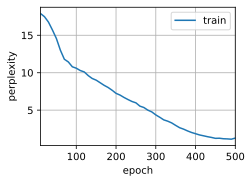

In [34]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.1, 10375.3 词元/秒 cpu
time traveller whol this new parsoul ablenthirbyer another at me
traveller so the bery lips of homer and platothe very young


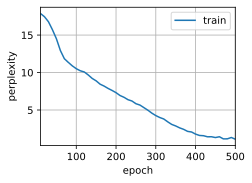

In [39]:
# 简洁版
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 深度循环神经网络

困惑度 1.0, 12782.2 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


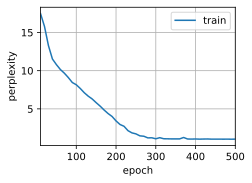

In [40]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

# (**双向循环神经网络的错误应用**)

由于双向循环神经网络使用了过去的和未来的数据，
所以我们不能盲目地将这一语言模型应用于任何预测任务。
尽管模型产出的困惑度是合理的，
该模型预测未来词元的能力却可能存在严重缺陷。
我们用下面的示例代码引以为戒，以防在错误的环境中使用它们。

困惑度 1.1, 11410.8 词元/秒 cpu
time traveller sure it anach ard said filby ano whit y a call th
travellerioc one might now se man lo gratked andais a fout 


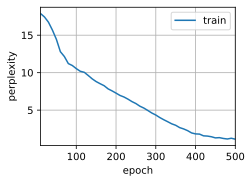

In [42]:
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
# 训练模型
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)